In [3]:
"""
This script is used to analyze data and produce Figure 2CDE of the manuscript
'Plasmid-mediated phenotypic noise leads to transient antibiotic resistance in bacteria'.

MIT License

Copyright (c) 2023 JCRHB/RPM

""";


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from cycler import cycler
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import ScalarFormatter
from scipy.stats import linregress,skew
import scipy.stats as stats


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
rootDir = "/content/drive/MyDrive/SYNC_Projects/"

rootDir = rootDir + "pBGT/GIT/"
workingDir = rootDir + "code"

data_path = rootDir + "data/LB-AMP-LB/"
fig_path = rootDir + "figures/"

dark_orange='#FF985A'
light_orange='#FFDC97'
dark_blue='#779ECC'
light_blue='#9FC0DE'


## Figure 2C

In [8]:
# Define variables
fileName = 'pBGT_LB-AMP-LB_AMNIS.csv'   # The name of the data file to load
strain = 'plasmid'   # The type of strain being analyzed
reps = ['A', 'B', 'F']   # A list of replicate names in the data file
cols = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]   # A list of column indices in the data file for the relevant data
As = [0, 1/256, 1/128, 1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1]   # A list of different concentration levels
strAs = ['AMP=0', '1/256 MIC', '1/128 MIC', '1/64 MIC', '1/32 MIC', '1/16 MIC', '1/8 MIC', '1/4 MIC', '1/2 MIC', 'MIC']   # A list of labels for the concentration levels
lim_aspect = [.25, .75]   # A list of minimum and maximum values for aspect ratio to filter the data
lim_area = [25, 35]   # A list of minimum and maximum values for area to filter the data
xmax = 3e5 #.75e6   # The maximum value for the x-axis in the plot
xmin = .9e4   # The minimum value for the x-axis in the plot
xdelta = .5e4   # The spacing between ticks on the x-axis
numDays = 3   # The total number of days in the experiment
day = 2   # The day to plot data for

# Load data
filePath = data_path + fileName   # The full path to the data file
data = pd.read_csv(filePath, delimiter='\t')   # Load data from the file into a pandas DataFrame
seasondata_df = data[data['season'] == day]   # Select data for the given day
print(seasondata_df.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 677289 entries, 825000 to 1502288
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Object Number          677289 non-null  int64  
 1   Area_M01               677289 non-null  float64
 2   Area_M02               677289 non-null  float64
 3   Area_M04               677289 non-null  float64
 4   Aspect Ratio_M01       677289 non-null  float64
 5   Aspect Ratio_M02       677289 non-null  float64
 6   Aspect Ratio_M04       677289 non-null  float64
 7   Gradient RMS_M01_Ch01  677289 non-null  float64
 8   Gradient RMS_M02_Ch02  677289 non-null  float64
 9   Gradient RMS_M04_Ch04  677289 non-null  float64
 10  Intensity_MC_Ch02      677289 non-null  float64
 11  strain                 677289 non-null  object 
 12  season                 677289 non-null  int64  
 13  treatment              677289 non-null  object 
 14  replicate              677289 

The **plot_dose_histograms()** function creates a figure with dose-response histograms for GFP intensity for different doses. The function loops through each dose level and each replicate, filters the data based on area and aspect ratio, creates a histogram of GFP intensities, normalizes it, and stores it in a list. Then, it calculates the mean of the replicate histograms. For each dose level, the function plots the distribution of GFP intensity.

0MIC   Day2   pBGT_LB-AMP-LB_AMNIS.csv: 1298 cells
0MIC   Day2   pBGT_LB-AMP-LB_AMNIS.csv: 434 cells
0MIC   Day2   pBGT_LB-AMP-LB_AMNIS.csv: 337 cells
skewness:  1.86
0.00390625MIC   Day2   pBGT_LB-AMP-LB_AMNIS.csv: 1305 cells
0.00390625MIC   Day2   pBGT_LB-AMP-LB_AMNIS.csv: 951 cells
0.00390625MIC   Day2   pBGT_LB-AMP-LB_AMNIS.csv: 1196 cells
skewness:  2.04
0.0078125MIC   Day2   pBGT_LB-AMP-LB_AMNIS.csv: 1028 cells
0.0078125MIC   Day2   pBGT_LB-AMP-LB_AMNIS.csv: 879 cells
0.0078125MIC   Day2   pBGT_LB-AMP-LB_AMNIS.csv: 1153 cells
skewness:  2.04
0.015625MIC   Day2   pBGT_LB-AMP-LB_AMNIS.csv: 1167 cells
0.015625MIC   Day2   pBGT_LB-AMP-LB_AMNIS.csv: 1523 cells
0.015625MIC   Day2   pBGT_LB-AMP-LB_AMNIS.csv: 727 cells
skewness:  1.63
0.03125MIC   Day2   pBGT_LB-AMP-LB_AMNIS.csv: 2499 cells
0.03125MIC   Day2   pBGT_LB-AMP-LB_AMNIS.csv: 724 cells
0.03125MIC   Day2   pBGT_LB-AMP-LB_AMNIS.csv: 824 cells
skewness:  1.52
0.0625MIC   Day2   pBGT_LB-AMP-LB_AMNIS.csv: 1075 cells
0.0625MIC   Day2

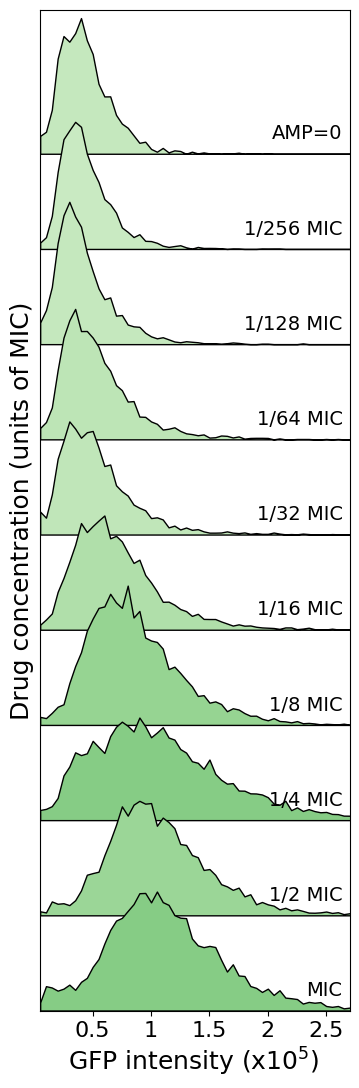

In [9]:


def plot_dose_histograms(df):
    # Define dose numbers and colors
    doses = np.unique(df['dose number'])
    colors = sns.color_palette('Greens', n_colors=len(doses))

    # Define colormap
    CT2 = LinearSegmentedColormap.from_list('CT2', colors)

    # Create figure
    fig = plt.figure(figsize=(4, 13))
    ax = fig.add_subplot(1, 1, 1)

    ymax = 1
    xmin = .5e4
    # Loop over all As
    for iA in range(len(As)):
        iAx = iA + 2

        # Get data for this dose level
        asData = df[df['dose number'] == iAx]

        repH = []
        # Loop over all replicates
        for irep in range(len(reps)):
            repname = 'rep-' + str(irep+1)

            # Get data for this replicate at this dose level
            asrepData = asData[asData['replicate'] == repname]

            # Filter data based on area and aspect ratio
            thisGFP = asrepData['Intensity_MC_Ch02'][(asrepData['Area_M02'] > lim_area[0]) &
                                                     (asrepData['Area_M02'] < lim_area[1]) &
                                                     (asrepData['Aspect Ratio_M02'] > lim_aspect[0]) &
                                                     (asrepData['Aspect Ratio_M02'] < lim_aspect[1])]

            # Print number of cells
            print(str(As[iA]) + 'MIC   Day' + str(day) + '   ' + fileName + ': ' + str(len(thisGFP)) + ' cells')

            # Create histogram
            e = np.arange(xmin, xmax + xdelta, xdelta)
            h, bins = np.histogram(thisGFP[(thisGFP > xmin) & (thisGFP < xmax)], bins=e)

            # Normalize histogram
            hnorm = h / max(h)
            repH.append(hnorm)

        # Plot bar graph of the replicate means
        ypos = (len(As) - iA) * 0.66

        mean_repH = np.mean(repH, axis=0)
        mean_repH[np.isnan(mean_repH)] = 0 # Replace NaN values with zeros

        # Define the value for which to get the color
        value = np.floor(np.mean(1.5 * mean_repH) * 100)

        # Get the color for the value from the colormap
        thisColor = CT2(value / 100)

        # Plot the filled area with the color
        mean_repH = np.concatenate([mean_repH, [0]])  # Add an extra bin to match the length of e
        plt.fill_between(e, np.ones_like(mean_repH) * ypos + mean_repH, np.ones_like(mean_repH) * ypos, color=thisColor, edgecolor='k', alpha=1)

        this_sk=round(skew(mean_repH),2)
        print("skewness: ",this_sk)


        # Set plot properties
        plt.xlim(0.9*xmin, 0.9 * xmax)
        plt.ylim(0.66, (len(As))* 0.76)
        plt.xticks(ticks=[0.5e5, 1e5, 1.5e5, 2e5, 2.5e5], labels=['0.5','1','1.5','2','2.5'], fontsize=16)

        if iA == 0:
            plt.xlabel("GFP intensity (x$10^5$) ", fontsize=18)
        if iA < len(As) - 1:
            plt.yticks(ticks=[], fontsize=16)

        if iA == len(As) - 1:
            plt.ylabel('Drug concentration (units of MIC)', fontsize=18)
        plt.text(0.88 * xmax, ypos + 0.075, strAs[iA], fontsize=14, horizontalalignment='right', verticalalignment='bottom')
        ####### Skewness text
        #plt.text(0.88 * xmax, ypos + 0.5, "Skewness: %s"%this_sk, fontsize=10, horizontalalignment='right', verticalalignment='bottom')

        plt.tick_params(axis='both', labelsize=16)

    return fig


fig2C=plot_dose_histograms(seasondata_df)
out_fig_name=fig_path+"Fig-2C.pdf"
print("Saving fig as: \n",out_fig_name)
plt.savefig(out_fig_name,bbox_inches = 'tight',pad_inches = 0.1)
plt.show()



## Figure 2D

In [10]:
data_path_D = rootDir + "data/Figure_2/"
strains_pcn_file=data_path_D+"strains_characterization_pBGT_evo.txt"
print(strains_pcn_file)
strains_fluorescence_file=data_path_D+"all_strains.csv"
print(strains_fluorescence_file)

/content/drive/MyDrive/SYNC_Projects/pBGT/GIT/data/Figure_2/strains_characterization_pBGT_evo.txt
/content/drive/MyDrive/SYNC_Projects/pBGT/GIT/data/Figure_2/all_strains.csv


In [11]:
df_flourescence=pd.read_csv(strains_fluorescence_file,sep='\t')
display(df_flourescence.describe())
#strains=df_flourescence.strain.unique()
strains=["MG","MGGT","pBGT","G54U","G55U"]

,ids,Area_M02,Area_M04,Aspect Ratio_M02,Aspect Ratio_M04,Gradient RMS_M02_Ch02,Gradient RMS_M04_Ch04,GFP,Intensity_MC_Ch04
count,125000.000000,125000.000000,125000.000000,125000.000000,125000.000000,125000.000000,125000.000000,125000.000000,125000.000000
mean,12499.500000,20.429444,33.589809,0.423247,0.603086,18.981395,65.838408,43222.888464,1304.564501
std,7216.907227,22.044148,19.080660,0.330478,0.145048,15.078538,4.567607,55953.068258,2024.886512
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-690.357143,-6560.839286
25%,6249.750000,0.000000,20.000000,0.000000,0.499089,0.000000,62.070930,519.247984,-165.434975
50%,12499.500000,17.666667,27.222222,0.551622,0.601973,22.591545,65.240189,19784.117424,576.782781
75%,18749.250000,32.222222,44.444444,0.699519,0.705299,31.144132,69.204102,68689.136201,2295.788419
max,24999.000000,284.000000,199.333333,1.000000,1.000000,62.452951,98.216695,549004.355769,18785.894231


In [12]:
df_pcn=pd.read_csv(strains_pcn_file,sep='\t',dtype=str)
df_pcn

,Strain name,Fitness *,PCN,CMI CAZ (mg l-1),CMI AMP (mg l-1)
0,MG,1.003 ± 0.011,NaN,0.25,4
1,MG::blaTEM-1,NaN,NaN,0.25,512
2,MG/pBGT,0.943 ± 0.013,19.12 ± 1.56,0.5,"8,192"
3,MG::blaTEM-1 R146,1.008 ± 0.011,NaN,0.5,128
4,MG/pBGT R164S,0.943 ± 0.003,21.10 ± 0.85,64,"4,096"
5,MG/pBGT G54U,0.793 ± 0.019,44.50 ± 3.81,0.5,"32,768"
6,MG/pBGT G55U,0.557 ± 0.116,88.93 ± 15.65,1,"32,768"
7,MG/pBGT R164S G54U,0.762 ± 0.016,52.30 ± 2.19,128,"4,096"
8,MG/pBGT R164S G55U,0.509 ± 0.082,127.29 ± 4.58,128,"8,192"


MG  VC: 2.083505180211872 12761 57.53817280976922 47.88290952548196 -250 400
0.9993628873242165
MGGT  VC: 0.4010336711528503 16201 808.5180649086572 768.7878073908792 100.0 5000.0
0.7602299997501489
pBGT  VC: 0.3528604599898296 3971 21439.041895458013 21473.786856874452 3000.0 100000.0
0.9120340965556946
G54U  VC: 0.2621348115240427 4310 72388.02710011232 72479.92650393635 10000.0 300000.0
0.928614441065212
G55U  VC: 0.30020141855700516 4191 96441.12958144993 96441.12958144993 1000.0 300000.0
0.993200172262908


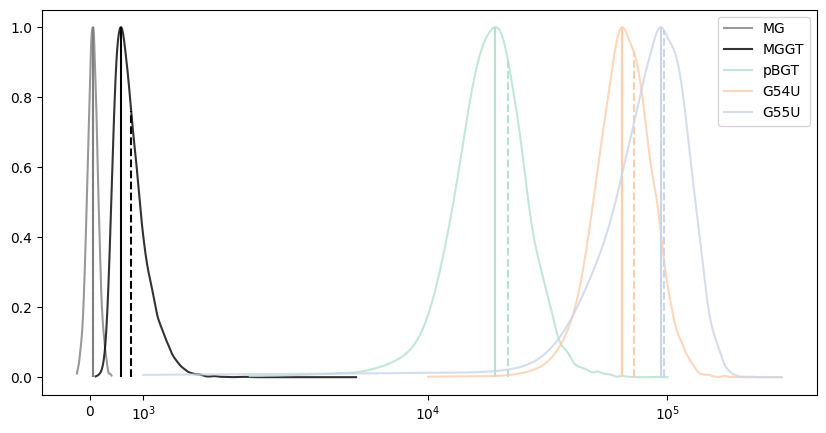

{'MG': [47.88290952548196, 99.76429003995806, 51.90190190190191],
 'MGGT': [768.7878073908792, 308.3097967355147, 575.7757757757759],
 'pBGT': [21473.786856874452, 7577.250308040277, 19118.118118118116],
 'G54U': [72479.92650393635, 18999.511873385825, 64864.86486486486],
 'G55U': [96441.12958144993, 28951.763907591223, 93782.78278278279]}

In [13]:
pltdf=df_flourescence.copy()
df_list=[]

straindf=pltdf[pltdf["strain"]=="MG"].copy()
straindf.describe()
this_df=straindf[(straindf.Area_M04 >40 )
                    & (straindf.Area_M04 <60 )
                    &(straindf["Aspect Ratio_M04"] > 0.25)
                    &(straindf["Aspect Ratio_M04"] < 0.75)
                        ]

df_list.append(this_df)

straindf=pltdf[pltdf["strain"]=="MGGT"].copy()
this_df=straindf[(straindf.Area_M04 >1 )
                    & (straindf.Area_M04 <50 )
                    &(straindf["Aspect Ratio_M04"] > 0.25)
                    &(straindf["Aspect Ratio_M04"] < 0.75)
                        ]
df_list.append(this_df)


for strain in strains[2:]:

    straindf=pltdf[pltdf["strain"]==strain].copy()

    min4A=straindf.Area_M04.describe()["25%"]
    max4A=straindf.Area_M04.describe()["75%"]

    min4AR=straindf["Aspect Ratio_M04"].describe()["25%"]
    max4AR=straindf["Aspect Ratio_M04"].describe()["75%"]

    min4RMS=straindf["Gradient RMS_M02_Ch02"].describe()["min"]
    max4RMS=straindf["Gradient RMS_M02_Ch02"].describe()["50%"]

    this_df=straindf[
                        (straindf.Area_M04 >min4A )
                        & (straindf.Area_M04 <max4A )
                      & (straindf["Aspect Ratio_M04"] > min4AR)
                        &(straindf["Aspect Ratio_M04"] < max4AR)
                        &(straindf["Gradient RMS_M02_Ch02"] > min4RMS)
                        &(straindf["Gradient RMS_M02_Ch02"] < max4RMS)
                        ]
    df_list.append(this_df)


focused_df=pd.concat(df_list)


fig,ax=plt.subplots(figsize=(10,5))


maxs=[400,5e3,1e5,3e5,3e5]
mins=[-250,1e2,3e3,1e4,1e3]
#mins=[1,10,10,10,10]

colors = sns.color_palette('Pastel2', n_colors=4)
color_MG = (0, 0, 0)
color_pBGT = colors[0]
color_G54U = colors[1]
color_G55U = colors[2]

fl_strain_stats=dict()

tcolors=['gray',color_MG,color_pBGT,color_G54U,color_G55U]
for i,strain in enumerate(strains):

    this_df=focused_df[focused_df["strain"]==strain].copy()
    this_gs=np.array(this_df["GFP"])

    max_g=maxs[i]
    min_g=mins[i]
    tmean0=this_gs.mean()
    tsd0=this_gs.std()
    #max_g=tmean+5*tsd
    #min_g=tmean-2*tsd
    this_gs=this_gs[np.where(this_gs>min_g)[0]]
    this_gs=this_gs[np.where(this_gs<max_g)[0]]
    tmean=this_gs.mean()
    tsd=this_gs.std()
    vc=tsd/tmean


    print(strain," VC:",vc,len(this_gs),tmean0,tmean,min_g,max_g)

    #xs=np.linspace(-1,max_g,100)
    xs=np.linspace(min_g,max_g,1000)


    den=gaussian_kde(this_gs)
    #ys=den(xs)
    ys=den.evaluate(xs)
    ymax=ys.max()
    ys=ys/ymax
    xi=np.where(ys==1)[0]
    tmode=xs[xi][0]
    ym=den.evaluate(tmean)[0]/ymax
    print(ym)
    fl_strain_stats[strain]=[tmean,tsd,tmode]
    #ax.hist(this_gs,color=tcolors[i])
    ax.plot(xs,ys,label=strain,alpha=.8,c=tcolors[i])
    ax.vlines(x=tmode,ymin=0,ymax=1,color=tcolors[i])
    ax.vlines(x=tmean,ymin=0,ymax=ym,ls="dashed",color=tcolors[i])

plt.legend()
plt.xscale("symlog",linthresh= 5000)
plt.show()
fl_strain_stats


In [14]:
table_strains_names=["MG","MG::blaTEM-1","MG/pBGT","MG/pBGT G54U","MG/pBGT G55U"]
plt_strains_names=["WT","MG:GT","MG/pBGT","MG/G54U","MG/G55U"]

plt_res=[]
strain_fitness=[]
strain_pcns_raw=[]
for this_strain in table_strains_names:
    this_pcn=str(df_pcn[df_pcn["Strain name"]==this_strain]["PCN"].item()).replace(' ', '')
    this_res=int(df_pcn[df_pcn["Strain name"]==this_strain]["CMI AMP (mg l-1)"].item().replace(',', ''))
    this_fitness=str(df_pcn[df_pcn["Strain name"]==this_strain]["Fitness *"].item())
    if this_fitness=="nan":
        this_fitness='1'
    if this_pcn=="nan":
        this_pcn='1'
    print(this_pcn,this_res,this_fitness)
    plt_res.append(this_res)
    strain_fitness.append(this_fitness)
    strain_pcns_raw.append(this_pcn)

plt_res2=[x/plt_res[1] for x in plt_res]  #<-- relative to MGGT

strain_cost=[1-float(x.split(" ")[0]) for x in strain_fitness]
strain_pcns=[float(x.split("±")[0]) for x in strain_pcns_raw]
strain_pcns_sd=[]
for x in strain_pcns_raw:
    if("±" in x):
        tsd=float(x.split("±")[1])
    else:
        tsd=0
    strain_pcns_sd.append(tsd)
strain_pcns,strain_pcns_raw,strain_cost,strain_pcns_sd

1 4 1.003 ± 0.011
1 512 1
19.12±1.56 8192 0.943 ± 0.013
44.50±3.81 32768 0.793 ± 0.019
88.93±15.65 32768 0.557 ± 0.116


([1.0, 1.0, 19.12, 44.5, 88.93],
 ['1', '1', '19.12±1.56', '44.50±3.81', '88.93±15.65'],
 [-0.0029999999999998916,
  0.0,
  0.05700000000000005,
  0.20699999999999996,
  0.44299999999999995],
 [0, 0, 1.56, 3.81, 15.65])

[99.76429003995806, 308.3097967355147, 7577.250308040277, 18999.511873385825, 28951.763907591223]


/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1062: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


Saving fig as: 
 /content/drive/MyDrive/SYNC_Projects/pBGT/GIT/figures/Fig-2D.pdf


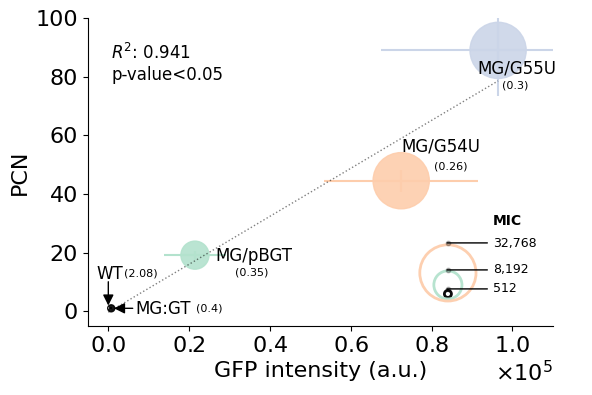

In [16]:
fig,ax= plt.subplots(figsize=(6,4))
fig.set_facecolor('white')
plt.rcParams.update({'font.size': 16})

xfmt = ScalarFormatter()
xfmt.set_powerlimits((0,3))  # Or whatever your limits are . . .
plt.gca().xaxis.set_major_formatter(xfmt)


plt_fls_means=[fl_strain_stats[s][0] for s in strains]
plt_fls_sd=[fl_strain_stats[s][1] for s in strains]
print(plt_fls_sd)
#plt_costs=[x*100 for x in fitness_costs_mumaxs]
plt_res2=[x*.05 for x in plt_res]

colors = sns.color_palette('Pastel2', n_colors=4)
color_MG = (0, 0, 0)
color_pBGT = colors[0]
color_G54U = colors[1]
color_G55U = colors[2]
tcolors=['gray',color_MG,color_pBGT,color_G54U,color_G55U]

######### The data
ax.scatter(plt_fls_means,strain_pcns,s=plt_res2, alpha=.9,c=tcolors)

for i,(xi,yi,ye,xe) in enumerate(zip(plt_fls_means,strain_pcns,strain_pcns_sd,plt_fls_sd)):
    ax.errorbar(x=xi,y=yi,yerr=ye,xerr=xe,c=tcolors[i])
##### The regression
lr_plot=linregress(plt_fls_means,strain_pcns)
lry_plot=[x*lr_plot.slope+lr_plot.intercept for x in plt_fls_means]
ax.plot(plt_fls_means,lry_plot,'k',label="regression",lw=1,ls=":",alpha=.5)
if lr_plot.pvalue<0.05:
  lbl_pvalue='<0.05'
else:
  lbl_pvalue='>=0.05'
ax.annotate(r"$R^2$: ""%s\np-value%s"%(round(lr_plot.rvalue**2,3),lbl_pvalue), xy=(0.05, 0.8), xycoords='axes fraction',fontsize=12)

# #### The names anotatoion
xdevs=[-3000,6000,5000,-5,-5000]
ydevs=[10,-2,-2,10,-8]
for i, txt in enumerate(plt_strains_names):
    ax.annotate(txt, (plt_fls_means[i]+xdevs[i],strain_pcns[i]+ydevs[i]),fontsize=12)

# #### The CoV anotatoion
xdevs2=[4000,21000,10000,8000,1000]
#ydevs=[16,2,-2,10,-15]
ydevs2=[11,-1,-7,4,-13]
for i, strain in enumerate(strains):
    mean,std,mod=fl_strain_stats[strain]
    this_cov=round(std/mean,2)
    ax.annotate("(%s)"%this_cov, (plt_fls_means[i]+xdevs2[i],strain_pcns[i]+ydevs2[i]),fontsize=8)


########### arrows
ax.annotate("", xy=(plt_fls_means[0],strain_pcns[0]),
             xytext=(plt_fls_means[0],strain_pcns[0]+ydevs[0]),color="k",arrowprops=dict(arrowstyle="-|>",color='k'))
ax.annotate("", xy=(plt_fls_means[1],strain_pcns[1]),
             xytext=(plt_fls_means[1]+xdevs[1],strain_pcns[1]),color="k",arrowprops=dict(arrowstyle="-|>",color='k'))





ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


# ##########              The inset      #########################
left, bottom, width, height = [0.65, 0.15, 0.3, 0.25]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.annotate("MIC", (.5,.85),fontsize=10,fontweight="bold")
plt_pcns=[x*25 for x in strain_pcns]
ax2.scatter(.25,.16,s=plt_res2[1],facecolors="None", edgecolors=tcolors[1], lw=2,alpha=0.95)
ax2.scatter(.25,.25,s=plt_res2[2],facecolors="None", edgecolors=tcolors[2], lw=2,alpha=0.95)
ax2.scatter(.25,.37,s=plt_res2[3],facecolors="None", edgecolors=tcolors[3], lw=2,alpha=0.95)

ax2.annotate(f"{plt_res[3]:,.0f}", xy=(.23,.67),xytext=(.5,.67),color="k",verticalalignment="center",arrowprops=dict(arrowstyle="-",color='k'),fontsize=9)
ax2.annotate(f"{plt_res[2]:,.0f}", xy=(.23,.4),xytext=(.5,.4),color="k",verticalalignment="center",arrowprops=dict(arrowstyle="-",color='k'),fontsize=9)
ax2.annotate(f"{plt_res[1]:,.0f}", xy=(.23,.21),xytext=(.5,.21),color="k",verticalalignment="center",arrowprops=dict(arrowstyle="-",color='k'),fontsize=9)

ax2.scatter(.25,.67,s=10,c='k',alpha=0.25)
ax2.scatter(.25,.4,s=10,c='k',alpha=0.25)
ax2.scatter(.25,.21,s=10,c='k',alpha=0.25)

ax2.axis("off")
ax2.set_xlim([0,1])
ax2.set_ylim([0,1])
ax2.set_xticks([])
ax2.set_yticks([])

ax.xaxis.major.formatter._useMathText = True


ax.set_xlabel("GFP intensity (a.u.)")
ax.set_ylabel("PCN")

ax.set_ylim([-5,100])
ax.set_xlim([-5000,1.1e5])
# ax.set_xlim([10,1e5])
#ax.set_xscale("symlog",linthresh= 1e5)

out_fig_name=fig_path+"Fig-2D.pdf"
print("Saving fig as: \n",out_fig_name)
plt.savefig(out_fig_name,bbox_inches = 'tight',pad_inches = 0.1)
plt.show()




# Figure 2E


In [17]:
pBGT_file=data_path+"pBGT_LB-AMP-LB_AMNIS.csv"
pBGT_df=pd.read_csv(pBGT_file,sep="\t")
pBGT_df.head()
pBGT_dfbk=pBGT_df.copy()

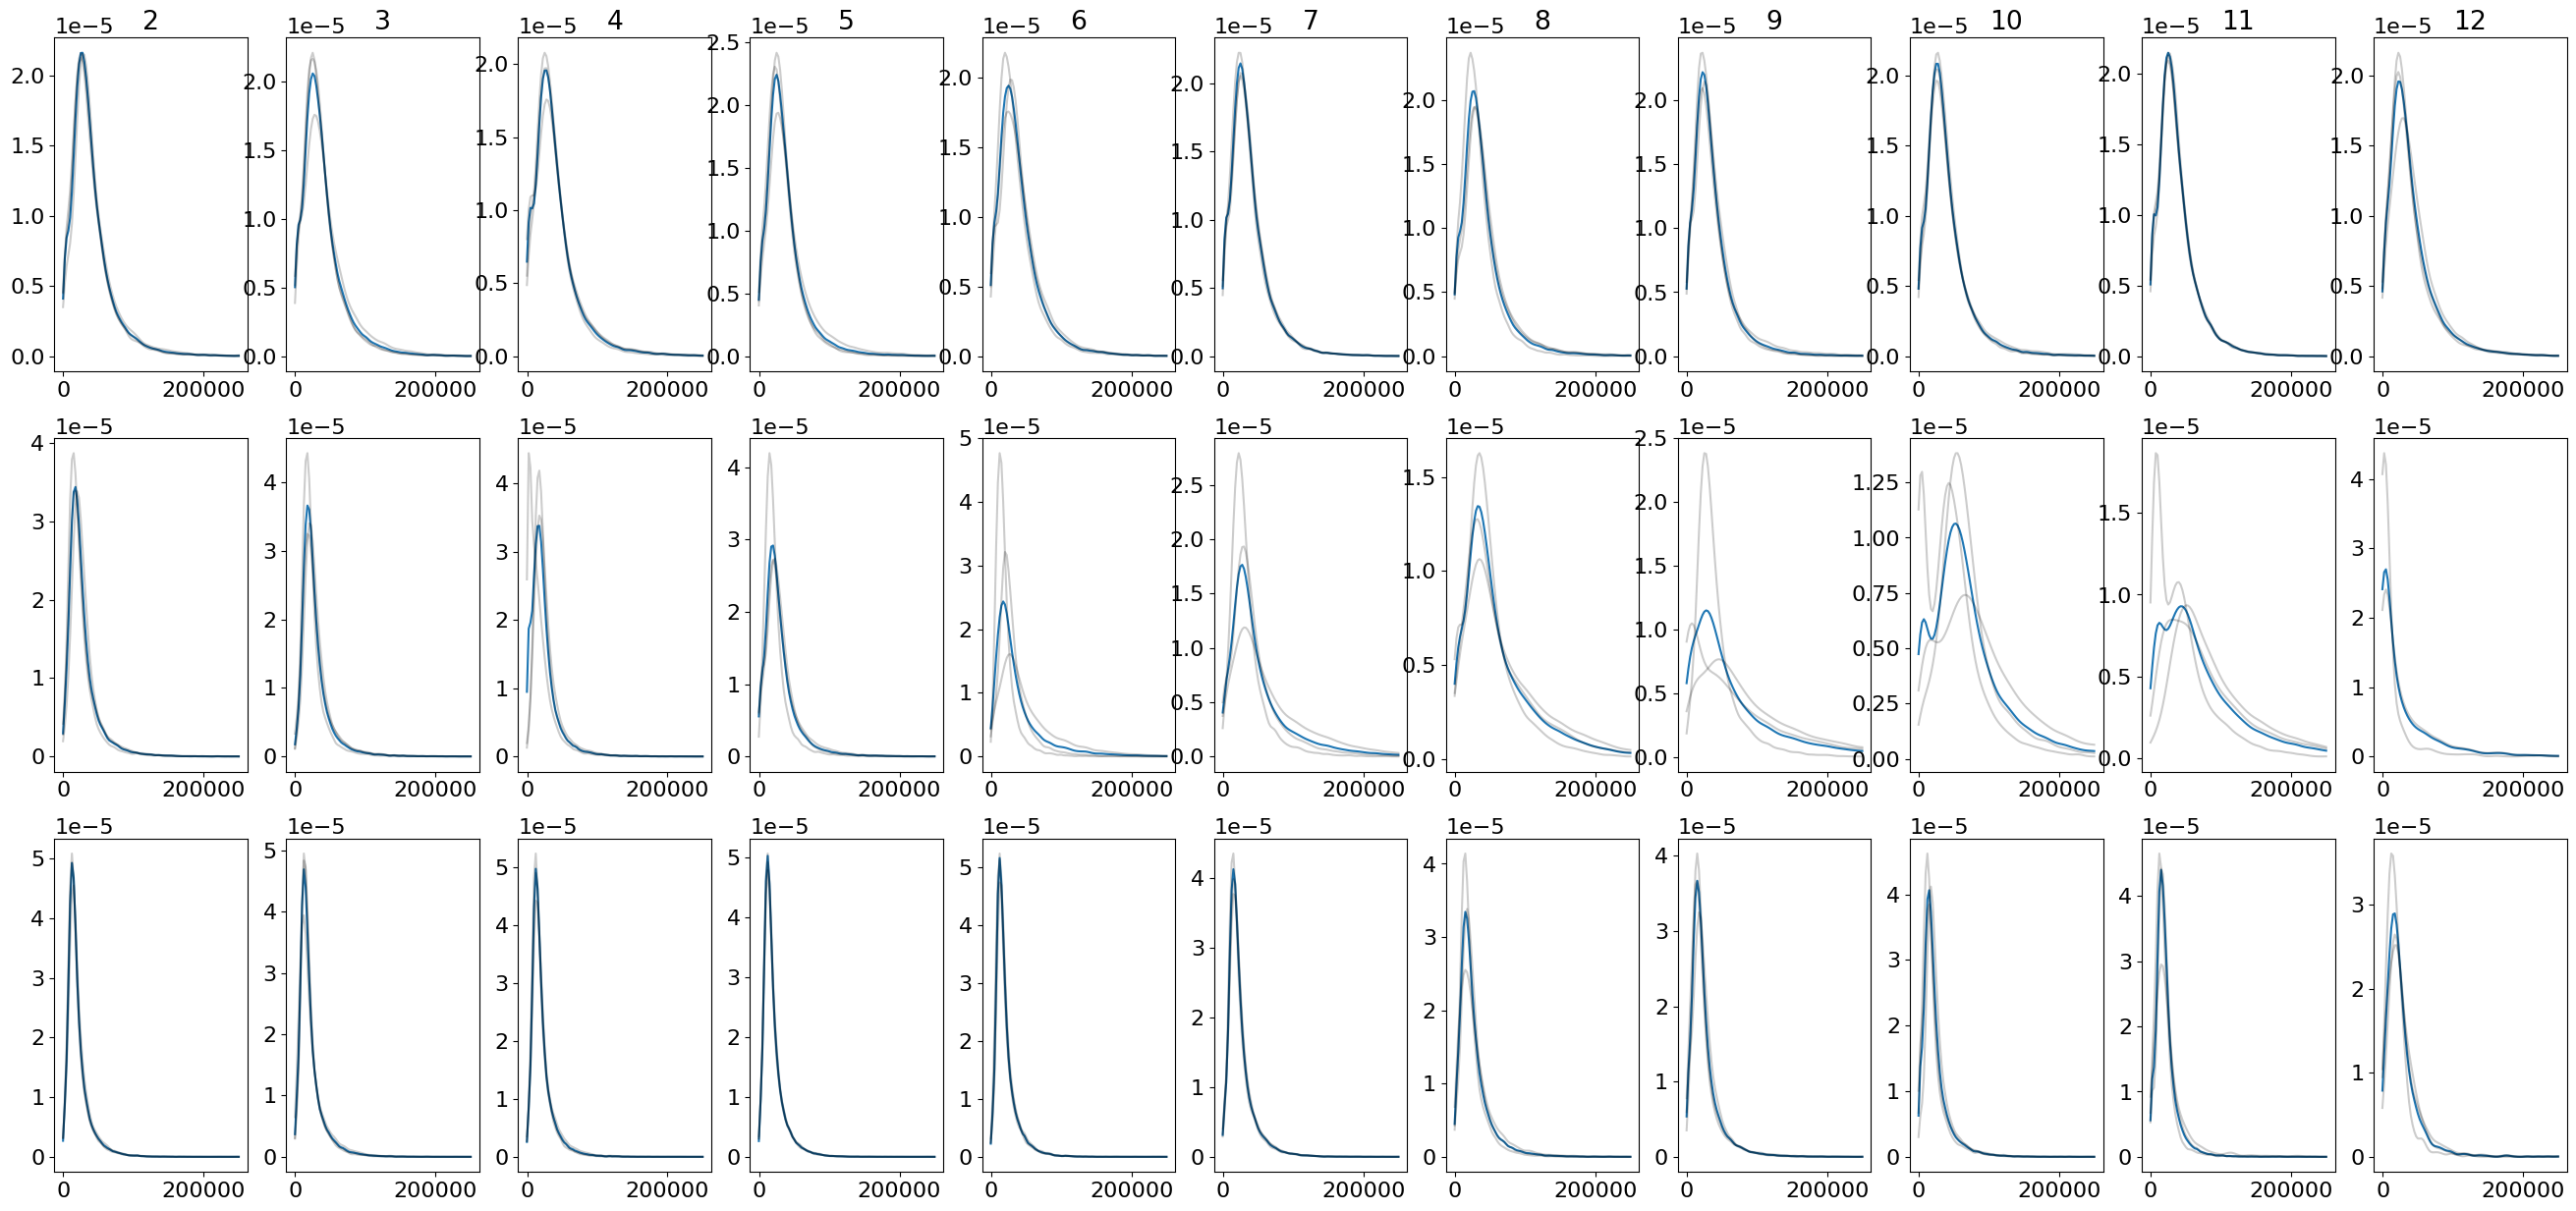

In [18]:
cols=pBGT_df["dose number"].unique()
rows=pBGT_df["season"].unique()
cols.sort()
ncols=len(cols)
nrows=len(rows)

this_g=pBGT_df["Intensity_MC_Ch02"]
maxg=this_g.max()
ming=this_g.min()
maxg=250000


xs=np.linspace(ming,maxg,100)

fig,ax=plt.subplots(nrows,ncols,figsize=(ncols*3,nrows*5))
for ic,col in enumerate(cols):
    col_df=pBGT_df[pBGT_df["dose number"]==col]
    ax[0,ic].set_title(col)
    for ir,row in enumerate(rows):
        row_df=col_df[col_df["season"]==row]
        this_gs=row_df["Intensity_MC_Ch02"]
        den=gaussian_kde(this_gs)
        ys=den(xs)
        ax[ir,ic].plot(xs,ys)
        reps=row_df["replicate"].unique()
        for rep in reps:
            t_df=row_df[row_df["replicate"]==rep]
            this_gs=t_df["Intensity_MC_Ch02"]
            den=gaussian_kde(this_gs)
            ys=den(xs)
            ax[ir,ic].plot(xs,ys,c='k',alpha=.2)
plt.show()

In [19]:
pBGT_df.describe()

,Object Number,Area_M01,Area_M02,Area_M04,Aspect Ratio_M01,Aspect Ratio_M02,Aspect Ratio_M04,Gradient RMS_M01_Ch01,Gradient RMS_M02_Ch02,Gradient RMS_M04_Ch04,Intensity_MC_Ch02,season,dose number
count,2.218851e+06,2.218851e+06,2.218851e+06,2.218851e+06,2.218851e+06,2.218851e+06,2.218851e+06,2.218851e+06,2.218851e+06,2.218851e+06,2.218851e+06,2.218851e+06,2.218851e+06
mean,1.218011e+04,7.241700e+00,1.991302e+01,1.006086e+01,4.057555e-01,7.018840e-01,4.848781e-01,2.262738e+01,3.537221e+01,3.120160e+01,3.709237e+04,1.951129e+00,6.693421e+00
std,7.231463e+03,7.777288e+00,1.382116e+01,1.187161e+01,3.310165e-01,1.568337e-01,3.160669e-01,1.720896e+01,5.582092e+00,2.138246e+01,3.915732e+04,8.320870e-01,2.973775e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-3.066000e+02,1.000000e+00,2.000000e+00
25%,5.900000e+03,0.000000e+00,1.277778e+01,2.555556e+00,0.000000e+00,6.043848e-01,1.988788e-01,0.000000e+00,3.069644e+01,2.556216e+01,1.488347e+04,1.000000e+00,4.000000e+00
50%,1.198000e+04,6.666667e+00,1.744444e+01,8.222222e+00,4.924347e-01,7.177551e-01,5.674537e-01,3.050940e+01,3.477809e+01,3.368533e+01,2.580436e+04,2.000000e+00,7.000000e+00
75%,1.842400e+04,1.100000e+01,2.233333e+01,1.311111e+01,6.865516e-01,8.175091e-01,7.336339e-01,3.660453e+01,3.964094e+01,4.107023e+01,4.485338e+04,3.000000e+00,9.000000e+00
max,2.499900e+04,2.008889e+02,5.494444e+02,2.471111e+02,1.000000e+00,1.000000e+00,1.000000e+00,7.661710e+01,6.967141e+01,9.932112e+01,1.174104e+06,3.000000e+00,1.200000e+01


### Estimating CV for LB+AMP season pBGT

[ 2  3  4  5  6  7  8  9 10 11 12]
Rows: [2]
1000 300000.0
2069 46883.16292266842 23360.357788349356 0.4982675300060529
	 1298 47790.314755195264 24029.395224148462 0.5028088922878717
	 434 48877.600563894324 22129.623549931024 0.45275593103230366
	 337 40820.64359058569 21228.34481762709 0.5200394445158356
0.4918680892786704 

3451 46704.25073123647 23037.22876138169 0.4932576457323201
	 1304 50203.07364744979 25095.600648076103 0.49988175672887125
	 951 50334.0994122678 22946.162505972596 0.45587708479750777
	 1196 40003.204595448035 18902.21684397677 0.47251756540843864
0.47609213564493924 

3060 44940.349668941235 25287.843304761536 0.5626979649924317
	 1028 45438.42458625306 28296.908119760315 0.6227528435992753
	 879 48091.77061027277 26439.37520641056 0.549769219783372
	 1153 42093.758149056615 20842.49460917443 0.49514454222333537
0.5558888685353276 

3415 56891.873950121895 31938.004025237122 0.5613807703581312
	 1521 64510.332570384664 36446.43603702067 0.5649705184399012
	 1

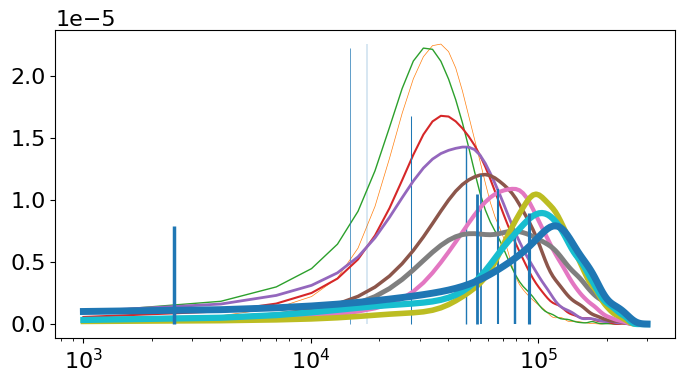

In [20]:

pBGT_df=pBGT_dfbk.copy()


lim_aspect=[.25, .75];
lim_area=[25, 35];



pBGT_df=pBGT_df[(pBGT_df["Area_M02"]>lim_area[0])&(pBGT_df["Area_M02"]<lim_area[1])
                &(pBGT_df["Aspect Ratio_M02"]>lim_aspect[0])&(pBGT_df["Aspect Ratio_M02"]<lim_aspect[1])
                &(pBGT_df["Intensity_MC_Ch02"]<2.5e5)
                #&(pBGT_df["Gradient RMS_M02_Ch02"]>40)
                #&(pBGT_df["Gradient RMS_M04_Ch04"]>0)
               ]



cols=pBGT_df["dose number"].unique()
cols.sort()
print(cols)

rows=pBGT_df["season"].unique()
rows=[2]
print("Rows:",rows)

ncols=len(cols)
nrows=len(rows)



this_g=pBGT_df["Intensity_MC_Ch02"]
maxg=this_g.max()
ming=this_g.min()
ming=1000
maxg=3e5

print(ming,maxg)
xs=np.linspace(ming,maxg,100)

pBGT_cvs=[]
pBGT_cvsx=[]
pBGT_cvsm=[]
pBGT_cvsxm=[]
pBGT_cvsm2=[]
pBGT_cvsxm2=[]


fig,ax=plt.subplots(figsize=(8,4))
for ic,col in enumerate(cols):
    col_df=pBGT_df[pBGT_df["dose number"]==col]
    #ax.set_title(col)
    for ir,row in enumerate(rows):
        row_df=col_df[col_df["season"]==row]

        this_gs=row_df["Intensity_MC_Ch02"]
        this_mean=np.mean(this_gs)
        this_sd=np.std(this_gs)
        this_cv=this_sd/this_mean
        pBGT_cvsm.append(this_cv)
        pBGT_cvsxm.append(ic)
        print(this_gs.size,this_mean,this_sd,this_cv)
        this_gs2=[int(x) for x in this_gs]
        den=gaussian_kde(this_gs)
        ys=den(xs)
        yma=max(ys)
        ax.plot(xs,ys,lw=ic*.5)
        xmode=stats.mode(this_gs2).mode
        ax.vlines(x=xmode,ymin=0,ymax=yma,lw=ic*.25)
        reps=row_df["replicate"].unique()
        mcv=[]

        for rep in reps:
            t_df=row_df[row_df["replicate"]==rep]
            this_gs=t_df["Intensity_MC_Ch02"]
            this_mean=np.mean(this_gs)
            this_sd=np.std(this_gs)
            this_cv=this_sd/this_mean
            pBGT_cvs.append(this_cv)
            pBGT_cvsx.append(ic)
            mcv.append(this_cv)
            print("\t",this_gs.size,this_mean,this_sd,this_cv)
            #ax.plot(xs,ys,c='k',alpha=.2)
        this_cv=np.mean(mcv)
        pBGT_cvsm2.append(this_cv)
        pBGT_cvsxm2.append(ic)
        print(this_cv,"\n")
#plt.yscale("log")
plt.xscale("log")
plt.show()




### Plotting CV vs Dose pBGT

lr0 LinregressResult(slope=-0.015874058008094587, intercept=0.5362340376849336, rvalue=-0.6289945557682809, pvalue=0.00019682628483566885, stderr=0.0037077634468617817, intercept_stderr=0.01979404023108229)
lrm LinregressResult(slope=-0.01350763998147787, intercept=0.5555003453320086, rvalue=-0.6167296827296183, pvalue=0.05754055868942838, stderr=0.006095522395797091, intercept_stderr=0.03254118480346746)
lrm2 LinregressResult(slope=-0.015874058008094594, intercept=0.5362340376849337, rvalue=-0.7777560362934176, pvalue=0.008082015097222445, stderr=0.004535766061240422, intercept_stderr=0.024214364584385913)


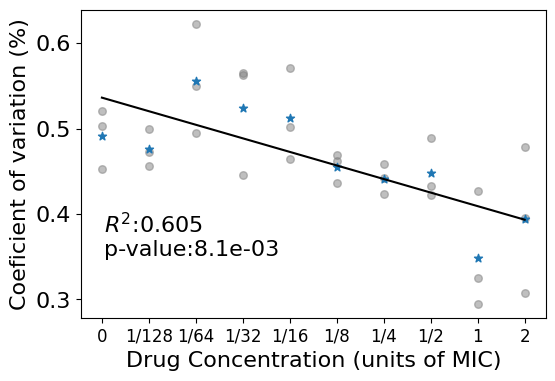

In [21]:
Doses=['0', '1/128', '1/64', '1/32', '1/16','1/8','1/4','1/2','1','2'];


fig=plt.figure(figsize=(6,4))
fig.set_facecolor('white')
plt.rcParams.update({'font.size': 16})

pBGT_tcvsx=pBGT_cvsx[0:-2]
pBGT_tcvs=pBGT_cvs[0:-2]

pBGT_tcvsxm=pBGT_cvsxm[0:-1]
pBGT_tcvsm=pBGT_cvsm[0:-1]
pBGT_tcvsxm2=pBGT_cvsxm2[0:-1]
pBGT_tcvsm2=pBGT_cvsm2[0:-1]

tcvsx_ticks=list(set(pBGT_tcvsx))

pBGT_lr0=linregress(pBGT_tcvsx,pBGT_tcvs)

print("lr0",pBGT_lr0)
pBGT_lrm=linregress(pBGT_tcvsxm,pBGT_tcvsm)

print("lrm",pBGT_lrm)
pBGT_lrm2=linregress(pBGT_tcvsxm2,pBGT_tcvsm2)

print("lrm2",pBGT_lrm2)

lr_plot=pBGT_lrm2 #<-------------------------- choose one for this
lry_plot=[x*lr_plot.slope+lr_plot.intercept for x in tcvsx_ticks]
plt.scatter(pBGT_tcvsx,pBGT_tcvs,s=30,c='gray',alpha=.5)
plt.scatter(pBGT_tcvsxm2,pBGT_tcvsm2,marker='*')
plt.plot(tcvsx_ticks,lry_plot,'k',label="regression")

plt.annotate(r"$R^2$:""%s\np-value:%s"%(round(lr_plot.rvalue**2,3),"{:.1e}".format(lr_plot.pvalue)), xy=(0.05, 0.2), xycoords='axes fraction')

#plt.ylim([.2,.7])

plt.xticks(tcvsx_ticks,labels=Doses,fontsize=12)

plt.ylabel("Coeficient of variation (%)")
plt.xlabel("Drug Concentration (units of MIC)")


plt.show()

### Loading MGGT data

In [22]:
MGGT_file=data_path+"MGGT_LB-AMP-LB_AMNIS.csv"
MGGT_df=pd.read_csv(MGGT_file,sep="\t")
MGGT_dfbk=MGGT_df.copy()

MGGT_df.head()

,Object Number,Area_M01,Area_M02,Area_M04,Aspect Ratio_M01,Aspect Ratio_M02,Aspect Ratio_M04,Gradient RMS_M01_Ch01,Gradient RMS_M02_Ch02,Gradient RMS_M04_Ch04,Intensity_MC_Ch02,strain,season,treatment,replicate,dose number
0,0,0.0,55.222222,0.0,0.0,0.502838,0.0,0.0,20.293874,0.0,3574.465116,MGGT,1,LB,rep-1,2
1,1,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,43.690217,MGGT,1,LB,rep-1,2
2,2,0.0,16.888889,0.0,0.0,0.698250,0.0,0.0,19.941072,0.0,1112.717391,MGGT,1,LB,rep-1,2
3,3,0.0,5.444444,0.0,0.0,0.664979,0.0,0.0,37.844659,0.0,569.486111,MGGT,1,LB,rep-1,2
4,4,0.0,14.666667,0.0,0.0,0.677321,0.0,0.0,28.464187,0.0,1919.706897,MGGT,1,LB,rep-1,2


[ 2  3  4  5  6  7  8  9 10 11 12]


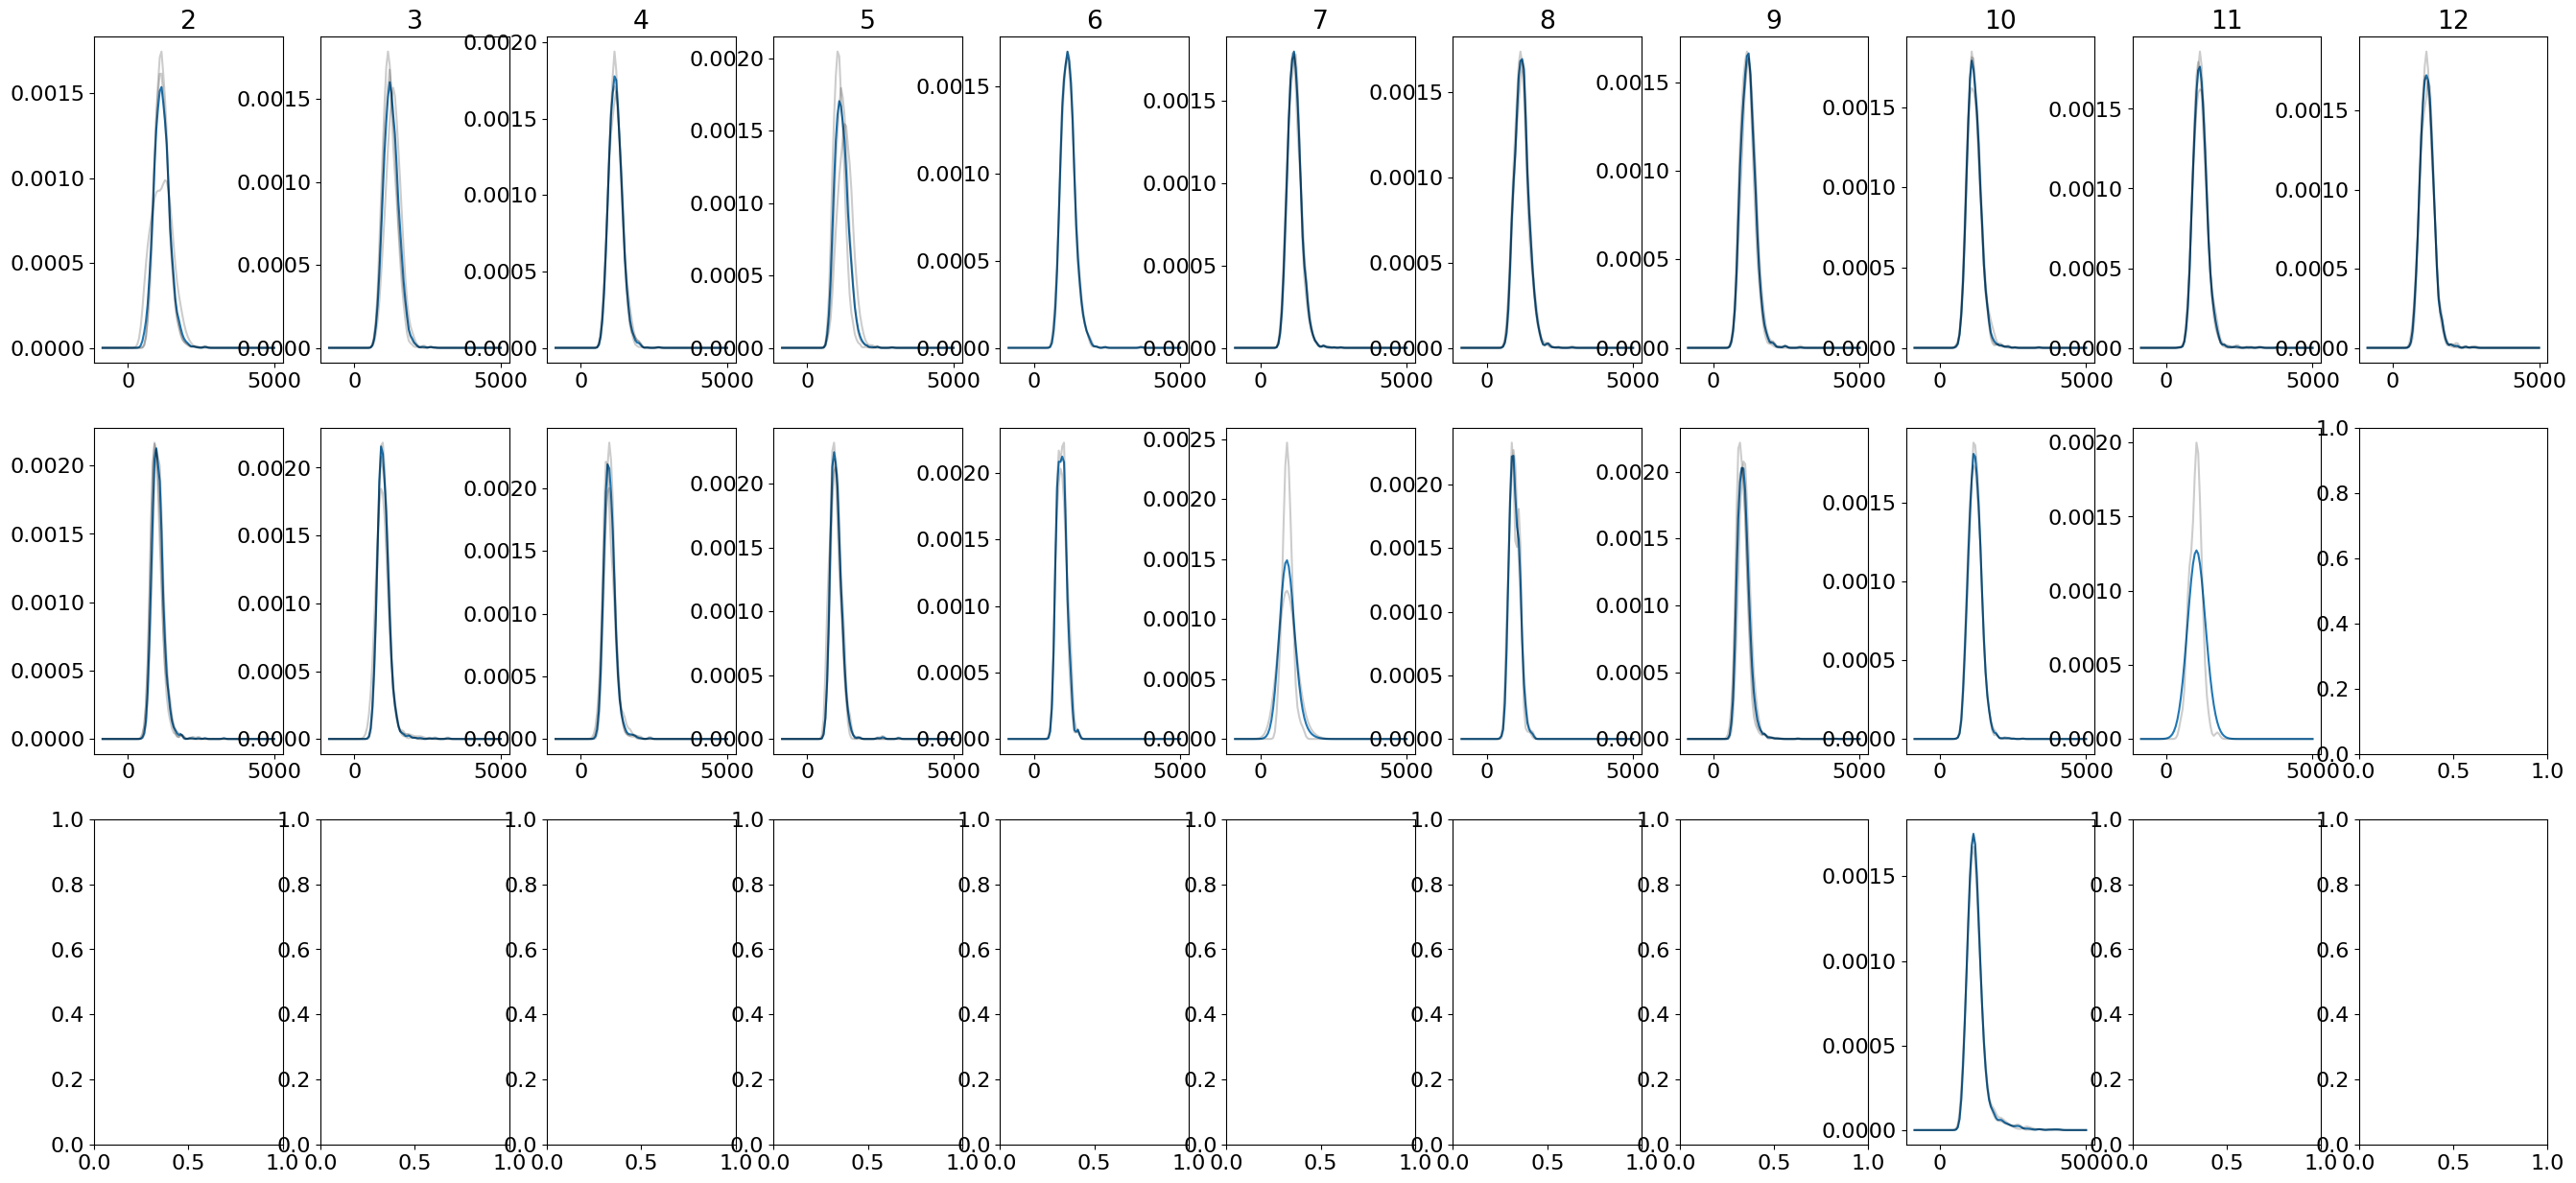

In [23]:


MGGT_df=MGGT_dfbk.copy()
cols=MGGT_df["dose number"].unique()
cols.sort()
print(cols)
rows=MGGT_df["season"].unique()
ncols=len(cols)
nrows=len(rows)

this_g=MGGT_df["Intensity_MC_Ch02"]
maxg=this_g.max()
ming=this_g.min()

maxg0=5e3

lim_aspect=[.4, .55];
lim_area=[5, 10];

MGGT_df=MGGT_df[(MGGT_df["Area_M02"]>lim_area[0])&(MGGT_df["Area_M02"]<lim_area[1])&
                (MGGT_df["Aspect Ratio_M02"]>lim_aspect[0])&(MGGT_df["Aspect Ratio_M02"]<lim_aspect[1])
                &(MGGT_df["Intensity_MC_Ch02"]<10000)
                #&(MGGT_df["Gradient RMS_M04_Ch04"]<1)
                &(MGGT_df["Gradient RMS_M02_Ch02"]>40)
                ]

xs=np.linspace(ming,maxg0,100)
fig,ax=plt.subplots(nrows,ncols,figsize=(ncols*3,nrows*5))
for ic,col in enumerate(cols):
    col_df=MGGT_df[MGGT_df["dose number"]==col]
    ax[0,ic].set_title(col)
    for ir,row in enumerate(rows):
        row_df=col_df[col_df["season"]==row]
        this_gs=row_df["Intensity_MC_Ch02"]

        if(len(this_gs)==0):
            continue
        den=gaussian_kde(this_gs)
        ys=den(xs)
        ax[ir,ic].plot(xs,ys)
        reps=row_df["replicate"].unique()
        for rep in reps:
            t_df=row_df[row_df["replicate"]==rep]
            this_gs=t_df["Intensity_MC_Ch02"]
            #print(ic,ir,rep,len(this_gs))
            if(this_gs.size<50):
                continue
             #   print(ic,ir,rep,len(this_gs))
                #ax[ir,ic].set_xscale("log")
                maxg=this_g.max()
                maxg=1e6
                maxg=5000
                xs=np.linspace(ming,maxg,100)
            den=gaussian_kde(this_gs)
            ys=den(xs)
            ax[ir,ic].plot(xs,ys,c='k',alpha=.2)
            maxg=maxg0
            xs=np.linspace(ming,maxg,100)


plt.show()


### Estimating CV for LB+AMP season

100 2500.0
2 1845 1027.675751264705 199.31692988691216 0.1939492389906287
	 1247 1046.7383250712421 193.9338171573227 0.18527440193242503
	 409 985.648119668747 207.61930521207037 0.21064242001683756
	 189 992.851792460446 197.35891729959428 0.19877983682791894
0.19823221959239387 

3 1648 997.2813394887023 198.94656260480514 0.19948890521385204
	 814 1001.8069908712712 191.96045560257002 0.19161421047343868
	 298 969.9966949907744 219.78552301266785 0.22658378543728774
	 536 1005.5778764942463 195.8618627791552 0.1947754294893498
0.20432447513335875 

4 1044 988.3708233007995 193.23635761623333 0.1955099776932853
	 315 979.8837891085445 216.30500171694115 0.22074556607751006
	 285 974.6170070917011 178.18386413259873 0.1828244970445437
	 444 1003.2204930984421 183.93823937268385 0.18334776914752948
0.19563927742319442 

5 1109 985.4289704446167 178.19459346180116 0.18082946493992497
	 80 941.3501941391999 168.2616715044713 0.17874503298778735
	 549 975.1774182929447 177.45692563779795

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


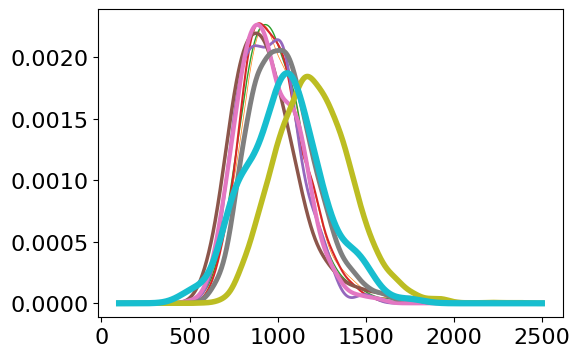

[0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 9, 9]
[0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8]


In [24]:


lim_aspect=[.4, .55];
lim_area=[5, 10];

# MGGT_df=MGGT_df[(MGGT_df["Area_M02"]>lim_area[0])&(MGGT_df["Area_M02"]<lim_area[1])&
#                 (MGGT_df["Aspect Ratio_M02"]>lim_aspect[0])&(MGGT_df["Aspect Ratio_M02"]<lim_aspect[1])
#                 &(MGGT_df["Intensity_MC_Ch02"]<10000)
#                 #&(MGGT_df["Gradient RMS_M04_Ch04"]<1)
#                 &(MGGT_df["Gradient RMS_M02_Ch02"]>40)
#                 ]

cols=MGGT_df["dose number"].unique()
cols.sort()
rows=MGGT_df["season"].unique()
rows=[2]
ncols=len(cols)
nrows=len(rows)



this_g=MGGT_df["Intensity_MC_Ch02"]
maxg=this_g.max()
ming=this_g.min()
ming=100
maxg=2.5e3

print(ming,maxg)
xs=np.linspace(ming,maxg,1000)

MGGT_cvs=[]
MGGT_cvsx=[]
MGGT_cvsm=[]
MGGT_cvsxm=[]
MGGT_cvsm2=[]
MGGT_cvsxm2=[]


fig,ax=plt.subplots(figsize=(6,4))
for ic,col in enumerate(cols):
    col_df=MGGT_df[MGGT_df["dose number"]==col]
    #ax.set_title(col)
    for ir,row in enumerate(rows):
        row_df=col_df[col_df["season"]==row]
        row_df=row_df[row_df["Intensity_MC_Ch02"]<maxg]
        this_gs=row_df["Intensity_MC_Ch02"]
        this_mean=np.mean(this_gs)

        this_sd=np.std(this_gs)
        this_cv=this_sd/this_mean
        MGGT_cvsm.append(this_cv)
        MGGT_cvsxm.append(ic)
        print(col,this_gs.size,this_mean,this_sd,this_cv)
        if(this_gs.size>0):
            den=gaussian_kde(this_gs)
            ys=den(xs)
            yma=max(ys)
            ax.plot(xs,ys,lw=ic*.5)
        #ax.vlines(x=this_mean,ymin=0,ymax=yma,lw=ic*.5)
        reps=row_df["replicate"].unique()
        mcv=[]

        for rep in reps:
            t_df=row_df[row_df["replicate"]==rep]
            this_gs=t_df["Intensity_MC_Ch02"]
            this_mean=np.mean(this_gs)
            this_sd=np.std(this_gs)
            this_cv=this_sd/this_mean
            if(this_gs.size<10):
                #this_cv=np.nan
                continue
            MGGT_cvs.append(this_cv)
            MGGT_cvsx.append(ic)
            mcv.append(this_cv)
            print("\t",this_gs.size,this_mean,this_sd,this_cv)
            #ax.plot(xs,ys,c='k',alpha=.2)
        this_cv=np.mean(mcv)
        MGGT_cvsm2.append(this_cv)
        MGGT_cvsxm2.append(ic)
        print(this_cv,"\n")
#plt.yscale("log")
#plt.xscale("log")
plt.show()
print(MGGT_cvsx)
print(MGGT_cvsx[0:-2])

### Plotting CV vs Dose MGGT

lr0 LinregressResult(slope=-0.001041499875150912, intercept=0.19509708405226703, rvalue=-0.18463704042833728, pvalue=0.3665452190331333, stderr=0.0011316259924400345, intercept_stderr=0.005740230066906267)
lrm LinregressResult(slope=0.00023180396919515828, intercept=0.18991746426739775, rvalue=0.05279127467848264, pvalue=0.8848403847544768, stderr=0.0015502713092509551, intercept_stderr=0.00827618404037574)
lrm2 LinregressResult(slope=-0.000821452455169202, intercept=0.1939024638040744, rvalue=-0.228476802630618, pvalue=0.525490004770829, stderr=0.0012375230599042312, intercept_stderr=0.006606565274645354)


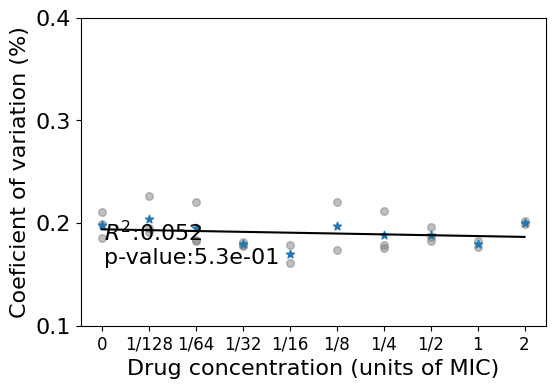

In [25]:
MGGT_Doses=['0', '1/128', '1/64', '1/32', '1/16','1/8','1/4','1/2','1'];
#strAs={'AMP=0','1/256 MIC', '1/128 MIC','1/64 MIC', '1/32 MIC','1/16 MIC','1/8 MIC','1/4 MIC','1/2 MIC','MIC'};


fig=plt.figure(figsize=(6,4))
fig.set_facecolor('white')
plt.rcParams.update({'font.size': 16})

MGGT_tcvsx=MGGT_cvsx[0:]
MGGT_tcvs=MGGT_cvs[0:]

MGGT_tcvsxm=MGGT_cvsxm[0:-1]
MGGT_tcvsm=MGGT_cvsm[0:-1]
MGGT_tcvsxm2=MGGT_cvsxm2[0:-1]
MGGT_tcvsm2=MGGT_cvsm2[0:-1]

tcvsx_ticks=list(set(MGGT_tcvsx))

MGGT_lr0=linregress(MGGT_tcvsx,MGGT_tcvs)
print("lr0",MGGT_lr0)

MGGT_lrm=linregress(MGGT_tcvsxm,MGGT_tcvsm)
print("lrm",MGGT_lrm)

MGGT_lrm2=linregress(MGGT_tcvsxm2,MGGT_tcvsm2)
print("lrm2",MGGT_lrm2)

lr_plot=MGGT_lrm2  #<-------------------------- change this
lry_plot=[x*lr_plot.slope+lr_plot.intercept for x in tcvsx_ticks]
plt.scatter(MGGT_tcvsx,MGGT_tcvs,s=30,c='gray',alpha=.5)
plt.scatter(MGGT_tcvsxm2,MGGT_tcvsm2,marker='*')
plt.plot(tcvsx_ticks,lry_plot,'k',label="regression")

plt.annotate(r"$R^2$:""%s\np-value:%s"%(round(lr_plot.rvalue**2,3),"{:.1e}".format(lr_plot.pvalue)), xy=(0.05, 0.2), xycoords='axes fraction')

plt.ylim([.1,.4])

plt.xticks(tcvsx_ticks,labels=Doses,fontsize=12)

plt.ylabel("Coeficient of variation (%)")
plt.xlabel("Drug concentration (units of MIC)")


plt.show()

## Plotting Figure 2E


MGGT linear regressions:
Using means by replicate means
lrm2 0.015 LinregressResult(slope=0.0020729673632398074, intercept=0.18937836031626956, rvalue=0.1227538841445856, pvalue=0.7354856870439503, stderr=0.005925366780525404, intercept_stderr=0.004327267809282082)
lrm2 0.556 LinregressResult(slope=-0.07146639308609472, intercept=0.4933315007633474, rvalue=-0.7454875396581931, pvalue=0.013323817313132522, stderr=0.022590684093079166, intercept_stderr=0.01649787155572068)
Saving fig as: 
 /content/drive/MyDrive/SYNC_Projects/pBGT/GIT/figures/Fig-2E.pdf


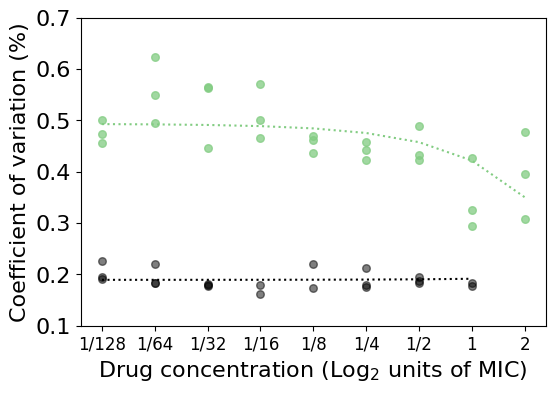

In [29]:
Doses=['0', '1/128', '1/64', '1/32', '1/16','1/8','1/4','1/2','1','2'];
DosesR=[0, 1/128, 1/64, 1/32, 1/16,1/8,1/4,1/2,1,2];

Doses_p=[0, 1/128, 1/64, 1/32, 1/16,1/8,1/4,1/2,1,2]
Doses_c=[0, 1/128, 1/64, 1/32, 1/16,1/8,1/4,1/2,1]



fig=plt.figure(figsize=(6,4))
fig.set_facecolor('white')
plt.rcParams.update({'font.size': 16})

MGGT_tcvsx=MGGT_cvsx[0:-2]
MGGT_tcvs=MGGT_cvs[0:-2]

MGGT_tcvsxm2=MGGT_cvsxm2[0:-1]
MGGT_tcvsm2=MGGT_cvsm2[0:-1]

tcvsx_ticks=list(set(MGGT_tcvsxm2))

MGGT_tcvsxR=[DosesR[tcvsx_ticks.index(x)] for x in MGGT_tcvsx]

MGGT_tcvsxRm=[DosesR[tcvsx_ticks.index(x)] for x in MGGT_tcvsxm2]

print("MGGT linear regressions:")


MGGT_lrm2=linregress(MGGT_tcvsxRm,MGGT_tcvsm2)
print("Using means by replicate means\nlrm2",round(MGGT_lrm2.rvalue**2,3),MGGT_lrm2)
mggt_color='k'
lr_plot=MGGT_lrm2  #<-------------------------- change this
lry_plot=[x*lr_plot.slope+lr_plot.intercept for x in MGGT_tcvsxRm[1:-1]]

plt.scatter(MGGT_tcvsxR,MGGT_tcvs,s=30,c=mggt_color,alpha=.5)
plt.plot(MGGT_tcvsxRm[1:-1],lry_plot,ls=':',label="regression",c=mggt_color)


#plt.annotate(r"$R^2$=%s"%(round(lr_plot.rvalue**2,3)), xy=(0.05, 0.15), xycoords='axes fraction',color=mggt_color,fontsize=12)


pBGT_tcvsx=pBGT_cvsx[0:-2]
pBGT_tcvs=pBGT_cvs[0:-2]

pBGT_tcvsxm2=pBGT_cvsxm2[0:-1]
pBGT_tcvsm2=pBGT_cvsm2[0:-1]

tcvsx_ticks=list(set(pBGT_tcvsxm2))

pBGT_tcvsxR=[DosesR[tcvsx_ticks.index(x)] for x in pBGT_tcvsx]
# print(pBGT_tcvsxR)

pBGT_tcvsxRm=[DosesR[tcvsx_ticks.index(x)] for x in pBGT_tcvsxm2]
# print(pBGT_tcvsxRm)


pBGT_lrm2=linregress(pBGT_tcvsxRm,pBGT_tcvsm2)
print("lrm2",round(pBGT_lrm2.rvalue**2,3),pBGT_lrm2)

pbgt_color='#82CC82'
lr_plot=pBGT_lrm2  #<-------------------------- change this
lry_plot=[x*lr_plot.slope+lr_plot.intercept for x in pBGT_tcvsxRm[1:]]

plt.scatter(pBGT_tcvsxR,pBGT_tcvs,s=30,c=pbgt_color,alpha=0.75)

plt.plot(pBGT_tcvsxRm[1:],lry_plot,ls=':',label="regression",c=pbgt_color)

#plt.annotate(r"$R^2$=""%s"%(round(lr_plot.rvalue**2,3)), xy=(0.05, 0.8), xycoords='axes fraction',color=pbgt_color,fontsize=12)

plt.ylim([.1,.7])
plt.xscale("log",base=2)
#plt.xscale("log")
plt.xticks(pBGT_tcvsxRm[1:],labels=Doses[1:],fontsize=12)
plt.ylabel("Coefficient of variation (%)")
plt.xlabel("Drug concentration (Log$_2$ units of MIC)")


#plt.rcParams.update({'font.size': 16})
out_fig_name=fig_path+"Fig-2E.pdf"
print("Saving fig as: \n",out_fig_name)
plt.savefig(out_fig_name,bbox_inches = 'tight',pad_inches = 0.1)
plt.show()
